In [1]:
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [2]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    return ["The answer to your question lies within."]


tools = [search]

In [3]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)

In [5]:
bound_model = model.bind_tools(tools)

In [6]:
from typing import Literal


def should_continue(state: State) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: State):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}

In [7]:
from langgraph.graph import START, StateGraph

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [9]:
app = workflow.compile(checkpointer=memory)


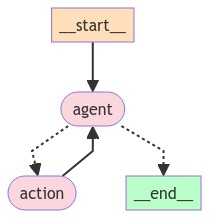

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hello Bob! How can I assist you today?


In [12]:
memory.storage

defaultdict(dict,
            {'2': {'1ef5eced-8ed8-6fb8-bfff-0a6e30ab56c5': (b'{"channel_values": {"__start__": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "type": "human"}, "lc": 1, "type": "constructor"}]}, "messages": []}, "channel_versions": {"__start__": 1}, "id": "1ef5eced-8ed8-6fb8-bfff-0a6e30ab56c5", "ts": "2024-08-20T08:33:16.749601+00:00", "v": 1, "versions_seen": {"__start__": {}, "action": {}, "agent": {}}}',
               b'{"source": "input", "step": -1, "writes": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "type": "human"}, "lc": 1, "type": "constructor"}]}}'),
              '1ef5eced-8ee1-6a28-8000-d0ef5caafff5': (b'{"channel_values": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "id": "a9aef5a3-b368-497c-b5fb-12ccffb78a54", "type": "human"}, "lc": 1, "type": "construct

In [13]:
input_message = HumanMessage(content="You forgot??")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

You forgot??
================================== Ai Message ==================================

I apologize for that oversight, Bob. How can I assist you today?


In [14]:
memory.storage

defaultdict(dict,
            {'2': {'1ef5eced-8ed8-6fb8-bfff-0a6e30ab56c5': (b'{"channel_values": {"__start__": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "type": "human"}, "lc": 1, "type": "constructor"}]}, "messages": []}, "channel_versions": {"__start__": 1}, "id": "1ef5eced-8ed8-6fb8-bfff-0a6e30ab56c5", "ts": "2024-08-20T08:33:16.749601+00:00", "v": 1, "versions_seen": {"__start__": {}, "action": {}, "agent": {}}}',
               b'{"source": "input", "step": -1, "writes": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "type": "human"}, "lc": 1, "type": "constructor"}]}}'),
              '1ef5eced-8ee1-6a28-8000-d0ef5caafff5': (b'{"channel_values": {"messages": [{"id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m bob", "id": "a9aef5a3-b368-497c-b5fb-12ccffb78a54", "type": "human"}, "lc": 1, "type": "construct